# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [5]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [6]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [7]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [8]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

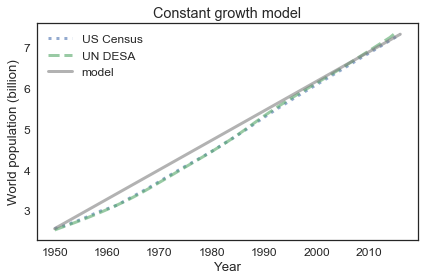

In [9]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [10]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [11]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file chap03-fig03.pdf


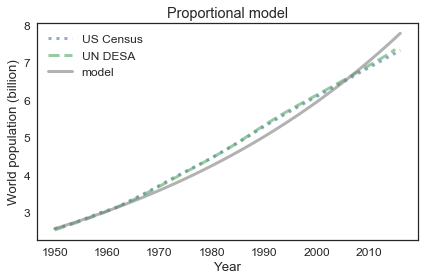

In [12]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('chap03-fig03.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [13]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print('t is ',t,'population is ',pop)
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [14]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [15]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [16]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [17]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


t is  1950.0 population is  2.557628654
t is  1951.0 population is  2.601108341118
t is  1952.0 population is  2.645327182917006
t is  1953.0 population is  2.6902977450265952
t is  1954.0 population is  2.7360328066920476
t is  1955.0 population is  2.7825453644058125
t is  1956.0 population is  2.829848635600711
t is  1957.0 population is  2.8779560624059233
t is  1958.0 population is  2.926881315466824
t is  1959.0 population is  2.9766382978297603
t is  1960.0 population is  3.0272411488928666
t is  1961.0 population is  3.078704248424045
t is  1962.0 population is  3.131042220647254
t is  1963.0 population is  3.184269938398258
t is  1964.0 population is  3.2384025273510284
t is  1965.0 population is  3.293455370315996
t is  1966.0 population is  3.349444111611368
t is  1967.0 population is  3.406384661508761
t is  1968.0 population is  3.46429320075441
t is  1969.0 population is  3.523186185167235
t is  1970.0 population is  3.583080350315078
t is  1971.0 population is  3.6439927

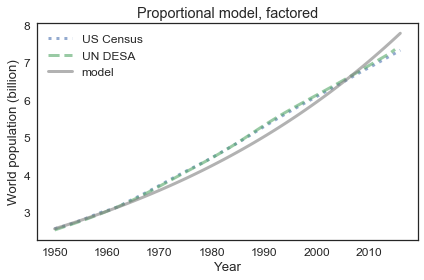

In [18]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

t is  1950.0 population is  2.557628654
t is  1951.0 population is  2.601108341118
t is  1952.0 population is  2.645327182917006
t is  1953.0 population is  2.6902977450265952
t is  1954.0 population is  2.7360328066920476
t is  1955.0 population is  2.7825453644058125
t is  1956.0 population is  2.829848635600711
t is  1957.0 population is  2.8779560624059233
t is  1958.0 population is  2.926881315466824
t is  1959.0 population is  2.9766382978297603
t is  1960.0 population is  3.0272411488928666
t is  1961.0 population is  3.078704248424045
t is  1962.0 population is  3.131042220647254
t is  1963.0 population is  3.184269938398258
t is  1964.0 population is  3.2384025273510284
t is  1965.0 population is  3.293455370315996
t is  1966.0 population is  3.349444111611368
t is  1967.0 population is  3.406384661508761
t is  1968.0 population is  3.46429320075441
t is  1969.0 population is  3.523186185167235
t is  1970.0 population is  3.583080350315078
t is  1971.0 population is  3.6439927

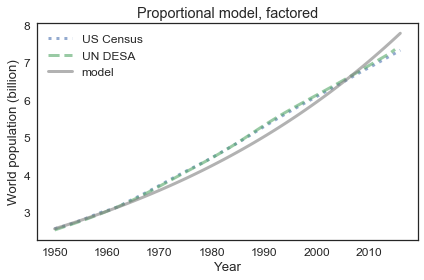

In [19]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [20]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

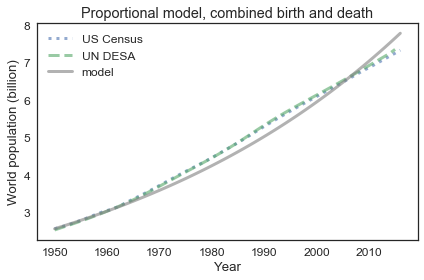

In [21]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [22]:
system = System(t_0=t_0, t_end=t_end, p_0=p_0, alpha1=0.02, alpha2=0.017)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha1,0.020000
alpha2,0.017000


In [28]:
def update_func2(pop, t, system):
    print('the year is ', t)

    if t < 1980:
        alpha = system.alpha1 
    else:
        alpha = system.alpha2 
        
    print('alpha is ', alpha)
    
    net_growth = alpha  * pop
    print('the net_growth is ', net_growth)
    
    return pop + net_growth
    

In [29]:
results = run_simulation(system, update_func2)

the year is  1950.0
alpha is  0.02
the net_growth is  0.051152573080000006
the year is  1951.0
alpha is  0.02
the net_growth is  0.052175624541600005
the year is  1952.0
alpha is  0.02
the net_growth is  0.053219137032432
the year is  1953.0
alpha is  0.02
the net_growth is  0.05428351977308064
the year is  1954.0
alpha is  0.02
the net_growth is  0.05536919016854225
the year is  1955.0
alpha is  0.02
the net_growth is  0.0564765739719131
the year is  1956.0
alpha is  0.02
the net_growth is  0.057606105451351364
the year is  1957.0
alpha is  0.02
the net_growth is  0.05875822756037839
the year is  1958.0
alpha is  0.02
the net_growth is  0.05993339211158595
the year is  1959.0
alpha is  0.02
the net_growth is  0.06113205995381767
the year is  1960.0
alpha is  0.02
the net_growth is  0.06235470115289402
the year is  1961.0
alpha is  0.02
the net_growth is  0.06360179517595191
the year is  1962.0
alpha is  0.02
the net_growth is  0.06487383107947095
the year is  1963.0
alpha is  0.02
the

,values
1950,2.557629
1951,2.608781
1952,2.660957
1953,2.714176
1954,2.768460
1955,2.823829
1956,2.880305
1957,2.937911
1958,2.996670
1959,3.056603


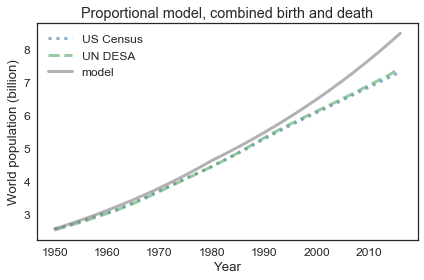

In [30]:

plot_results(census, un, results, 'Proportional model, combined birth and death')